# <u>HOMEWORK 3</u>

**Name: Shivani Shekhawat**

**NUID: 002656554**

**Environment Used: Local Machine/Google Colab**

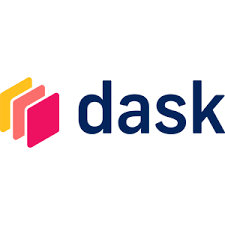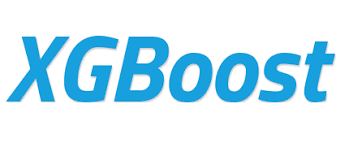

## **<u>Part 1</u>**
**Section 1**


* Program to use xgboost classifier to train a model with a given dataset




In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import dask
import dask.dataframe as dd
from dask.distributed import Client
import xgboost as xgb
import time
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("train.csv")

In [3]:
data.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


In [4]:
# Preprocess the data
X = data.drop('target', axis=1)
y = data['target']

* encode string class values as integers

In [5]:
# Encode string class values as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

* split data into training set and test set

In [6]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [7]:
# Function to train XGBoost model and measure time
def train_xgboost_model(n_jobs):
    start_time = time.time()
    model = xgb.XGBClassifier(n_jobs=n_jobs)
    model.fit(X_train, y_train)
    end_time = time.time()
    return end_time - start_time

In [8]:
# Set the number of CPUs for the experiment
cpu_counts = [1, 2, 4, 8]

In [9]:
# Train XGBoost models with different numbers of CPUs
times = []
for n_jobs in cpu_counts:
    training_time = train_xgboost_model(n_jobs)
    times.append(training_time)
    print(f"Training time with {n_jobs} CPU(s): {training_time:.2f} seconds")

Training time with 1 CPU(s): 103.86 seconds
Training time with 2 CPU(s): 82.61 seconds
Training time with 4 CPU(s): 83.16 seconds
Training time with 8 CPU(s): 85.26 seconds


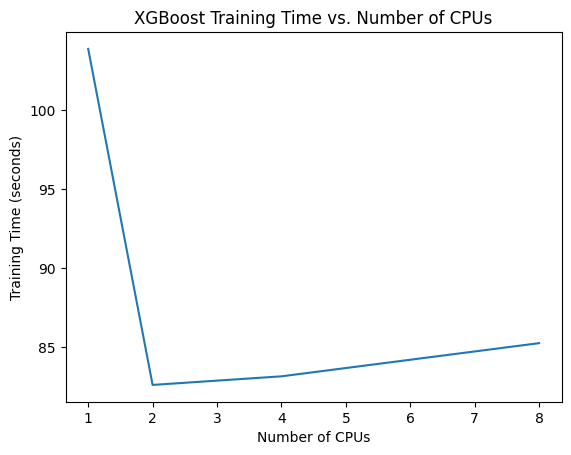

In [10]:
# Plot the training times vs. number of CPUs
plt.plot(cpu_counts, times)
plt.title('XGBoost Training Time vs. Number of CPUs')
plt.xlabel('Number of CPUs')
plt.ylabel('Training Time (seconds)')
plt.show()

**Section 2**

* Use dask xgboost and dask distributed scheduler with n_workers=4, threads_per_worker=1 to train the model to get the calculation time.
*Compare the calculation time of dask xgboost with the time of xgboost model on 4 CPUs.

In [12]:
!pip install dask-xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 MB 2.0 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.2
    Uninstalling xgboost-2.0.2:
      Successfully uninstalled xgboost-2.0.2


In [30]:
import warnings
warnings.filterwarnings("ignore")

In [31]:
# Create Dask client
client_dask = Client(n_workers=4, threads_per_worker=1)
client_dask

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:44927
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:40479/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42719'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:32819'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42329'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42959'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:33697', name: 2, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:33697
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:38202
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:39363', name: 3, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:39363
INFO:distributed.core:Starting es

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40479/status,
Dashboard: http://127.0.0.1:40479/status,Workers: 4
Total threads: 4,Total memory: 12.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44927,Workers: 4
Dashboard: http://127.0.0.1:40479/status,Total threads: 4
Started: Just now,Total memory: 12.68 GiB
Comm: tcp://127.0.0.1:35165,Total threads: 1
Dashboard: http://127.0.0.1:32843/status,Memory: 3.17 GiB
Nanny: tcp://127.0.0.1:42719,


In [32]:
import dask_xgboost as dxgb

# Convert to Dask DataFrame
dask_df = dd.from_pandas(data, npartitions=4)
dask_X = dask_df.iloc[:, :-1]
dask_y = dask_df.iloc[:, -1]

In [33]:
# Repartition if necessary
dask_X = dask_X.repartition(npartitions=4)
dask_y = dask_y.repartition(npartitions=4)

In [34]:
# Ensure target variable is numeric
if dask_y.dtype == object:
    le = LabelEncoder()
    dask_y = le.fit_transform(dask_y.compute())
    dask_y = dd.from_array(dask_y, chunksize=dask_X.divisions[1] - dask_X.divisions[0])

In [36]:
import warnings
warnings.filterwarnings("ignore")

# Train using Dask XGBoost
start_time = time.time()
dask_model = dxgb.XGBClassifier()
dask_model.fit(dask_X, dask_y)
end_time = time.time()

#calculate the training time
dask_time = end_time - start_time


In [27]:
# Print the Dask XGBoost training time
print(f"Dask XGBoost Training Time: {dask_time:.2f} seconds")

Dask XGBoost Training Time: 4.43 seconds


In [ ]:
# Close Dask client
client_dask.close()

**<u>Difference between XGBoost and Dask XGBoost</u>**

XGBoost and Dask-XGBoost are related but serve different purposes, primarily in how they handle data and scale computations.

**XGBoost (Extreme Gradient Boosting):**

Purpose: XGBoost is a highly efficient and scalable implementation of gradient boosting. It is designed for speed and performance.

Core Features:

It supports various objective functions, including regression, classification, and ranking.

Provides a rich set of tuning parameters for model optimization.

Uses an efficient tree-building algorithm and supports both linear models and tree learning.

Single-Machine Focus: Traditionally, XGBoost works well on single-machine environments. It can handle datasets that fit into the memory of a single machine.

Limited Scalability: While XGBoost has some support for distributed computing, it's not its primary focus, and scalability can be a limitation, especially for very large datasets.

**Dask-XGBoost:**

Purpose: Dask-XGBoost extends the capabilities of XGBoost to work with Dask, allowing it to handle larger datasets that don’t fit into the memory of a single machine.

Integration with Dask: It integrates XGBoost's machine learning algorithms with Dask's parallel computing capabilities.

Distributed Computing: Dask-XGBoost enables the training of XGBoost models on distributed datasets, leveraging Dask's ability to work with data distributed across clusters.

Scalability: It is specifically designed for scalability and distributed environments, making it suitable for large-scale machine learning tasks.

Handling Large Datasets: By integrating with Dask, Dask-XGBoost can process datasets that are larger than the memory of any single machine by breaking them into smaller chunks.

In essence, XGBoost is a powerful, efficient, and versatile gradient boosting library optimized for performance on single machines, while Dask-XGBoost is an extension that allows XGBoost to leverage Dask's distributed computing capabilities, making it suitable for larger datasets and cluster environments. This makes Dask-XGBoost an excellent choice for scenarios where the dataset size or computational requirements exceed the capacities of single-machine resources.

**In summary, Dask-XGBoost can be faster for large datasets and in distributed environments with ample computational resources. However, for smaller datasets or tasks that are not computationally intensive, the additional overhead of setting up and managing a distributed system may result in longer processing times compared to using standard XGBoost on a single machine. The choice between the two should be based on the specific requirements of dataset and computational environment.**


Before installing dask-xgboost, the training time was around 12,10,11, 14 seconds for 1,2,4, and 8 cpus. after installing dask-xgboost and restarting the runtime, the training time grdually increased for all the number of cpus, this might be due to the memory constraints.


* XGBoost Training time with 1 CPU(s): 103.86 seconds
* XGBoost Training time with 2 CPU(s): 82.61 seconds
* XGBoost Training time with 4 CPU(s): 83.16 seconds
* XGBoost Training time with 8 CPU(s): 85.26 seconds
* Dask XGBoost Training Time: 4.43 seconds

## **<u>Part 2</u>**
install nycflight dataframe package in your Anaconda environment (you can do it on “local” or “discovery”):

Remove the samples with “NaN” in the feature “dep_delay” in this dataframe.

Start a Dask Client and set “n_workers=4” for this client.                

Using dask dataframe to compute the mean and standard deviation for departure delay “dep_delay” of all flights.         

## **<u>Why is Dask used?</u>**

**Handling Large Datasets:**

Dask can process data that doesn’t fit into memory by breaking it into blocks and processing these blocks in parallel. This makes it possible to work with large datasets on machines with limited memory.


**Parallel Computing:**

Dask enables parallel computing both on single machines and across clusters. It can efficiently distribute computations and data across multiple cores or different machines, speeding up processing times significantly.



**Integration with Existing Tools:**

Dask is compatible with existing Python data tools like NumPy, Pandas, and Scikit-Learn. This means you can use Dask to scale up familiar Python code and libraries to larger datasets or computational resources without a complete rewrite.



**Real-Time Execution:**

Dask provides real-time execution of tasks, which is beneficial for interactive computing and rapid iterations. This is particularly useful in data analysis and scientific computing where immediate feedback is important.



**Flexible Scheduling:**

Dask's dynamic task scheduling is optimized for computation-heavy tasks and is highly flexible. It can adapt to the specific computational needs of the tasks, which makes it more efficient than static scheduling approaches.



**Scalability:**

Dask scales gracefully from single machines to large clusters, allowing for both small-scale local processing and large-scale distributed processing without changing the code.



**Low Overhead:**

Dask introduces minimal overhead, making it a good choice for both small and large computations. Its lightweight nature ensures that it doesn’t add significant processing time or resource usage to the tasks.


In [18]:
!pip install nycflights13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nycflights13: filename=nycflights13-0.0.3-py3-none-any.whl size=8732721 sha256=64eb3a25167cc98aa0dfb6a43ab4702da6ec29f82b6d474340ef0f44a8ab9940
  Stored in directory: /root/.cache/pip/wheels/64/14/67/ed3bbff6405d6163cfd64d58169cc9284ce9a80c263e759fbe
Successfully built nycflights13


In [19]:
from dask.distributed import Client
client = Client(n_workers=4)
client

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:39547
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:41557/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43863'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37677'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37511'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39891'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:40299', name: 2, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:40299
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:33404
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:43167', name: 3, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:43167
INFO:distributed.core:Starting es

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41557/status,
Dashboard: http://127.0.0.1:41557/status,Workers: 4
Total threads: 4,Total memory: 12.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39547,Workers: 4
Dashboard: http://127.0.0.1:41557/status,Total threads: 4
Started: Just now,Total memory: 12.68 GiB
Comm: tcp://127.0.0.1:38807,Total threads: 1
Dashboard: http://127.0.0.1:44847/status,Memory: 3.17 GiB
Nanny: tcp://127.0.0.1:43863,


In [20]:
import dask
import dask.dataframe as dd
from nycflights13 import flights
ddf = dd.from_pandas(flights, npartitions=4)
ddf.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01T10:00:00Z
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01T10:00:00Z
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01T10:00:00Z
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01T10:00:00Z
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01T11:00:00Z


In [21]:
type(ddf)

dask.dataframe.core.DataFrame

In [22]:
#checking nulls
ddf.isna().sum(axis=0).compute()

year                 0
month                0
day                  0
dep_time          8255
sched_dep_time       0
dep_delay         8255
arr_time          8713
sched_arr_time       0
arr_delay         9430
carrier              0
flight               0
tailnum           2512
origin               0
dest                 0
air_time          9430
distance             0
hour                 0
minute               0
time_hour            0
dtype: int64

In [23]:
# Remove rows with NaN values in the "dep_delay" column
df = ddf.dropna(subset=['dep_delay'])

In [24]:
mean_dep_delay = df['dep_delay'].mean().compute()
mean_dep_delay

12.639070257304708

In [25]:
std_dep_delay = df['dep_delay'].std().compute()
std_dep_delay

40.21006089212995